In [1]:
# Global packages
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import models, transforms
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading in the Dataset

In [35]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load the dataset
dataset = ImageFolder(root='../Dataset_BUSI_with_GT/', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [38]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self):
        super(MaskedAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (64, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 32, 32)
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (512, 8, 8)
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (256, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, x, mask_ratio=0.75):
        # Apply masking
        batch_size, _, H, W = x.shape
        num_patches = H * W
        mask = torch.rand(batch_size, 1, H, W, device=x.device) < mask_ratio

        x_masked = x * mask

        # Encode
        encoded = self.encoder(x_masked)

        # Decode
        decoded = self.decoder(encoded)

        return decoded, mask

In [39]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = nn.ModuleList(blocks)
        self.transform = resize

    def forward(self, input, target):
        if self.transform:
            input = nn.functional.interpolate(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = nn.functional.interpolate(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += nn.functional.l1_loss(x, y)
        return loss

In [40]:
# Instantiate the MaskedAutoencoder
model = MaskedAutoEncoder()
# Loss function and optimizer
epochs=50
optimizer = optim.Adam(maskedAutoencoder.parameters(), lr=1e-3)
perceptual_loss = VGGPerceptualLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
# Training the autoencoder
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs, mask = model(images)
        loss = perceptual_loss(outputs * (mask).float(), images * (mask).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, _ in val_loader:
            outputs, mask = model(images)
            loss = perceptual_loss(outputs * (~mask).float(), images * (~mask).float())
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/2], Train Loss: 1.5529, Val Loss: 1.4312
Epoch [2/2], Train Loss: 1.5528, Val Loss: 1.4310


# Plot the loss

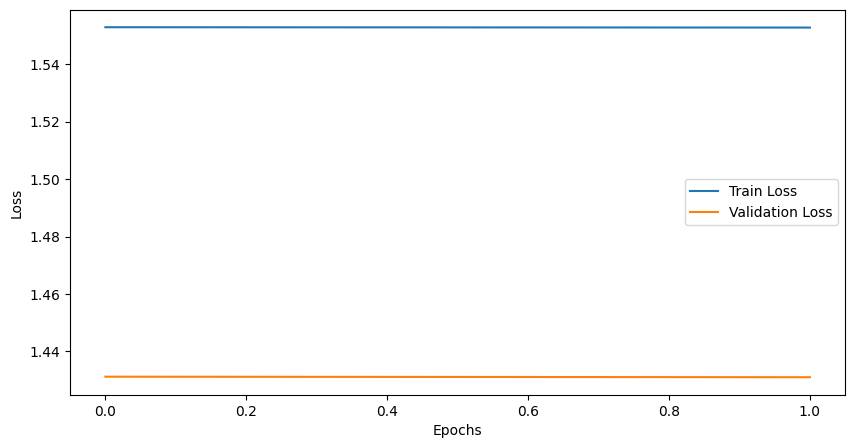

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), './models/mae-pixel-masking-with-perceptual-loss.pth')
print('Model saved to ./models/mae-pixel-masking-with-perceptual-loss.pth')

Model saved to /content/drive/MyDrive/LU_ML MS thesis/Project/maskedAutoencoder_busi-1.pth


In [ ]:
# Load the model
model = MaskedAutoEncoder()
model.load_state_dict(torch.load('./models/mae-pixel-masking-with-perceptual-loss.pth'))
print('Model loaded from ./models/mae-pixel-masking-with-perceptual-loss.pth')

# Ensure the model is in evaluation mode
model.eval()

Model loaded from /content/drive/MyDrive/LU_ML MS thesis/Project/maskedAutoencoder_busi-1.pth


MaskedAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1,

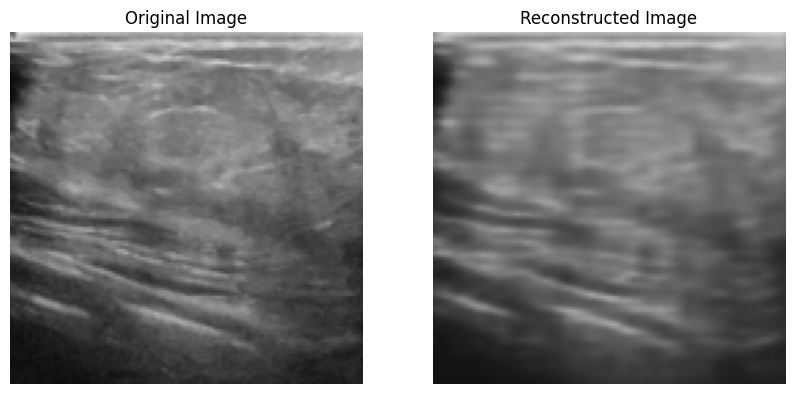

In [ ]:
# Function to display original and reconstructed images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a single image from the validation set
dataiter = iter(val_loader)
images, _ = next(dataiter)
image = images[12].unsqueeze(0)  # Get the first image and add a batch dimension

# Pass the image through the autoencoder
with torch.no_grad():
    reconstructed, _ = model(image)


# Function to unnormalize and convert tensor to numpy array for plotting
def unnormalize(tensor):
    tensor = tensor / 2 + 0.5  # Unnormalize
    return tensor.squeeze().permute(1, 2, 0).numpy()

# Plot the original and reconstructed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axs[0].imshow(unnormalize(image))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Reconstructed image
axs[1].imshow(unnormalize(reconstructed))
axs[1].set_title('Reconstructed Image')
axs[1].axis('off')

plt.show()